# 02_eda
- Author: 
- Date: 2025-10-23
- Goal: 분포/샘플/통계/시각화
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [1]:
# ============================================================
# 02_train_classical_ml.ipynb
#
# Train & Evaluate Classical ML Models on Colored MNIST
#
# Models:
#   - KNN
#   - SVM (RBF)
#   - Decision Tree
#   - Random Forest
#   - Logistic Regression
#
# Tasks:
#   1) Digit classification        (10 classes)
#   2) Foreground color classification (7 classes, ROYGBIV)
#   3) Background color classification (7 classes, ROYGBIV)
#
# Input:
#   data/processed/colored_mnist/colored_mnist.npz
#
# Output:
#   results/metrics/classical_ml_summary.csv
#   results/metrics/{task}_model_performance.csv
#   results/figures/cm_{task}_{model}.png
#   results/figures/fi_{task}_rf.png
#
# Note:
#   - No neural networks.
#   - Plots use English only to avoid font issues.
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

In [2]:
#------------------------------------------------------------
# [Cell 1] Paths & basic setup
# ------------------------------------------------------------

BASE_DIR = os.getcwd()  # run from repo root or adjust if needed

NPZ_PATH = os.path.join(
    BASE_DIR,
    "data",
    "processed",
    "colored_mnist",
    "colored_mnist.npz",
)

RESULTS_METRICS_DIR = os.path.join(BASE_DIR, "results", "metrics")
RESULTS_FIGURES_DIR = os.path.join(BASE_DIR, "results", "figures")

os.makedirs(RESULTS_METRICS_DIR, exist_ok=True)
os.makedirs(RESULTS_FIGURES_DIR, exist_ok=True)

RANDOM_SEED = 42

print("[INFO] BASE_DIR           :", BASE_DIR)
print("[INFO] NPZ_PATH           :", NPZ_PATH)
print("[INFO] RESULTS_METRICS_DIR:", RESULTS_METRICS_DIR)
print("[INFO] RESULTS_FIGURES_DIR:", RESULTS_FIGURES_DIR)


[INFO] BASE_DIR           : /Users/jaehun_jung/colored-mnist-classification/notebooks
[INFO] NPZ_PATH           : /Users/jaehun_jung/colored-mnist-classification/notebooks/data/processed/colored_mnist/colored_mnist.npz
[INFO] RESULTS_METRICS_DIR: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics
[INFO] RESULTS_FIGURES_DIR: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures


In [3]:
# ------------------------------------------------------------
# [Cell 2] Load preprocessed Colored MNIST
#   - Uses output of 01_preprocessing_colored_mnist.ipynb
# ------------------------------------------------------------

if not os.path.exists(NPZ_PATH):
    raise FileNotFoundError(
        f"{NPZ_PATH} not found.\n"
        "Run 01_preprocessing_colored_mnist.ipynb first."
    )

data = np.load(NPZ_PATH)

# standardized features (recommended for SVM/LogReg)
X_train = data["X_train"]
X_test = data["X_test"]

# raw features (optional for tree-based models)
X_train_raw = data["X_train_raw"]
X_test_raw = data["X_test_raw"]

# labels
y_digit_train = data["y_digit_train"]
y_digit_test = data["y_digit_test"]
y_fg_train = data["y_fg_train"]
y_fg_test = data["y_fg_test"]
y_bg_train = data["y_bg_train"]
y_bg_test = data["y_bg_test"]

# scaling params (if needed later)
mean = data["mean"]
std = data["std"]

print("[OK] Loaded colored_mnist.npz")
print("  X_train:", X_train.shape, "X_test:", X_test.shape)
print("  y_digit_train:", y_digit_train.shape, "y_digit_test:", y_digit_test.shape)
print("  y_fg_train:", y_fg_train.shape, "y_fg_test:", y_fg_test.shape)
print("  y_bg_train:", y_bg_train.shape, "y_bg_test:", y_bg_test.shape)

# Sanity check: same number of samples across labels
assert X_train.shape[0] == y_digit_train.shape[0] == y_fg_train.shape[0] == y_bg_train.shape[0]
assert X_test.shape[0] == y_digit_test.shape[0] == y_fg_test.shape[0] == y_bg_test.shape[0]

[OK] Loaded colored_mnist.npz
  X_train: (67093, 2352) X_test: (16774, 2352)
  y_digit_train: (67093,) y_digit_test: (16774,)
  y_fg_train: (67093,) y_fg_test: (16774,)
  y_bg_train: (67093,) y_bg_test: (16774,)


In [4]:
# ------------------------------------------------------------
# [Cell 3] Task definitions
#   - Wrap labels and class names in a dictionary for looping
# ------------------------------------------------------------

COLOR_NAMES = ["RED", "ORANGE", "YELLOW", "GREEN", "BLUE", "INDIGO", "VIOLET"]

tasks = {
    "digit": {
        "y_train": y_digit_train,
        "y_test": y_digit_test,
        "class_names": [str(i) for i in range(10)],
    },
    "fg_color": {
        "y_train": y_fg_train,
        "y_test": y_fg_test,
        "class_names": COLOR_NAMES,
    },
    "bg_color": {
        "y_train": y_bg_train,
        "y_test": y_bg_test,
        "class_names": COLOR_NAMES,
    },
}

print("[OK] Tasks defined:", list(tasks.keys()))

[OK] Tasks defined: ['digit', 'fg_color', 'bg_color']


In [5]:
# ------------------------------------------------------------
# [Cell 4] Model definitions
#   - Reasonable defaults for classical ML
#   - All use standardized X_train / X_test by default
#   - Tree-based models could also use raw features; we keep it consistent.
# ------------------------------------------------------------

def get_models(random_state=RANDOM_SEED):
    models = {
        "KNN": KNeighborsClassifier(
            n_neighbors=5,
            weights="distance",
            n_jobs=-1,
        ),
        "SVM": SVC(
            kernel="rbf",
            C=10.0,
            gamma="scale",
            probability=False,
            random_state=random_state,
        ),
        "DecisionTree": DecisionTreeClassifier(
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=random_state,
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=25,
            min_samples_split=5,
            min_samples_leaf=2,
            n_jobs=-1,
            random_state=random_state,
        ),
        "LogisticRegression": LogisticRegression(
            penalty="l2",
            C=2.0,
            solver="lbfgs",
            max_iter=1000,
            multi_class="multinomial",
            n_jobs=-1,
            random_state=random_state,
        ),
    }
    return models

models = get_models()
print("[OK] Models:", list(models.keys()))


[OK] Models: ['KNN', 'SVM', 'DecisionTree', 'RandomForest', 'LogisticRegression']


In [6]:
# ------------------------------------------------------------
# [Cell 5] Utility: metric computation
#   - Uses macro precision/recall/f1 for fair multi-class evaluation
# ------------------------------------------------------------

def compute_metrics(y_true, y_pred, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    return acc, prec, rec, f1

In [7]:
# ------------------------------------------------------------
# [Cell 6] Utility: confusion matrix plotting
# ------------------------------------------------------------

def plot_confusion_matrix(cm, class_names, title, save_path=None):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200)
    plt.show()
    plt.close()


==================== Task: digit ====================
[INFO] Training KNN on digit...
  KNN              | Acc=0.8256  Prec=0.8439  Rec=0.8228  F1=0.8269


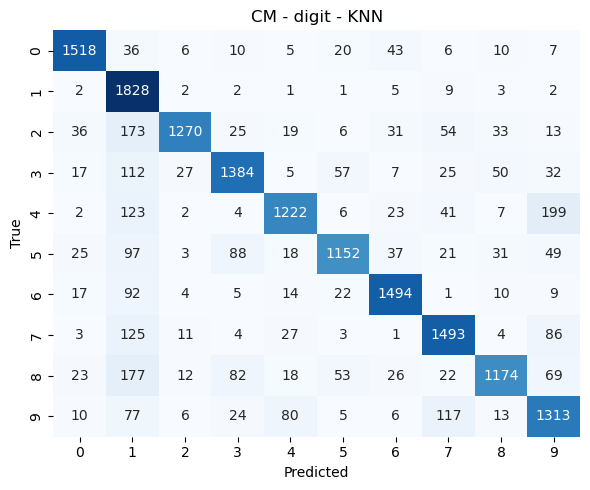

[INFO] Training SVM on digit...


In [ ]:
# ------------------------------------------------------------
# [Cell 7] Train & evaluate all models for all tasks
#   - For each (task, model):
#       1) fit
#       2) predict
#       3) compute metrics
#       4) save confusion matrix figure
#   - Save results into a summary DataFrame
# ------------------------------------------------------------

results = []

for task_name, task_info in tasks.items():
    print(f"\n==================== Task: {task_name} ====================")
    y_train_task = task_info["y_train"]
    y_test_task = task_info["y_test"]
    class_names = task_info["class_names"]

    # Use standardized features by default for all models
    Xtr = X_train
    Xte = X_test

    for model_name, model in get_models().items():
        print(f"[INFO] Training {model_name} on {task_name}...")

        # Fit
        model.fit(Xtr, y_train_task)

        # Predict
        y_pred = model.predict(Xte)

        # Metrics
        acc, prec, rec, f1 = compute_metrics(y_test_task, y_pred, average="macro")

        print(
            f"  {model_name:16s} | "
            f"Acc={acc:.4f}  Prec={prec:.4f}  Rec={rec:.4f}  F1={f1:.4f}"
        )

        # Confusion matrix
        cm = confusion_matrix(y_test_task, y_pred)
        cm_title = f"CM - {task_name} - {model_name}"
        cm_filename = f"cm_{task_name}_{model_name}.png"
        cm_path = os.path.join(RESULTS_FIGURES_DIR, cm_filename)
        plot_confusion_matrix(cm, class_names, cm_title, cm_path)

        # Store result row
        results.append({
            "task": task_name,
            "model": model_name,
            "accuracy": acc,
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1,
        })

In [ ]:
# ------------------------------------------------------------
# [Cell 8] Save metrics summary (all tasks/models)
# ------------------------------------------------------------

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["task", "f1_macro"], ascending=[True, False])

summary_path = os.path.join(RESULTS_METRICS_DIR, "classical_ml_summary.csv")
results_df.to_csv(summary_path, index=False)

print("\n[OK] Saved overall summary to:")
print(" ", summary_path)
print("\n[Summary head]")
display(results_df.head())

In [ ]:
# ------------------------------------------------------------
# [Cell 9] Save per-task metrics
#   - One CSV per task for easier reporting
# ------------------------------------------------------------

for task_name in tasks.keys():
    task_df = results_df[results_df["task"] == task_name].copy()
    task_csv_path = os.path.join(
        RESULTS_METRICS_DIR,
        f"{task_name}_model_performance.csv",
    )
    task_df.to_csv(task_csv_path, index=False)
    print(f"[OK] Saved {task_name} metrics to: {task_csv_path}")

In [ ]:
# ------------------------------------------------------------
# [Cell 10] Feature importance (RandomForest) visualization
#   - For each task, train RF once more and visualize top pixels.
#   - We sum importances over RGB channels to get 28x28 map.
# ------------------------------------------------------------

def visualize_rf_feature_importance(task_name, y_train_task, class_names):
    print(f"\n[INFO] Training RandomForest for feature importance ({task_name})")

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=30,
        min_samples_split=4,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )

    rf.fit(X_train, y_train_task)
    importances = rf.feature_importances_  # shape: (28*28*3,)

    if importances.shape[0] != 28 * 28 * 3:
        print("[WARN] Unexpected feature dimension; skip importance plot.")
        return

    # reshape to (28,28,3) and sum over channels
    imp_map = importances.reshape(28, 28, 3).sum(axis=2)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        imp_map,
        cmap="viridis",
        cbar=True,
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    plt.title(f"RF importance map - {task_name}")
    plt.tight_layout()

    fi_path = os.path.join(
        RESULTS_FIGURES_DIR,
        f"fi_{task_name}_rf.png",
    )
    plt.savefig(fi_path, dpi=200)
    plt.show()
    plt.close()

    print(f"[OK] Saved RF importance map for {task_name} to: {fi_path}")

# Run for each task
for task_name, task_info in tasks.items():
    visualize_rf_feature_importance(
        task_name,
        task_info["y_train"],
        task_info["class_names"],
    )

print("\n✅ All classical ML models trained and evaluated successfully.")
print("   - Check results/metrics/ and results/figures/ for outputs.")